# Tests of velocities of haloes in CSiBORG

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import csiborgtools

from scipy.stats import spearmanr, binned_statistic

%matplotlib inline
%load_ext autoreload
%autoreload 2

## FoF vs SPH velocity

In [ ]:
kind = "main"
nsnap = 99
nsim = 17417

field_reader = csiborgtools.read.CSiBORG2Field(nsim, kind)
catalogue = csiborgtools.read.CSiBORG2Catalogue(nsim, nsnap, kind)
boxsize = csiborgtools.simname2boxsize("csiborg2_main")

In [ ]:
velocity_field = field_reader.velocity_field("SPH", 1024)

In [ ]:
pos = catalogue["cartesian_pos"] / boxsize
vel = catalogue["cartesian_vel"]
mass = catalogue["totmass"]

spherical_pos = catalogue["spherical_pos"]
RA = np.deg2rad(spherical_pos[:, 1])
dec = np.deg2rad(spherical_pos[:, 2])

def project_radial(vx, vy, vz, RA, dec):
    return vx * np.cos(dec) * np.cos(RA) + vy * np.cos(dec) * np.sin(RA) + vz * np.sin(dec)

In [ ]:
vx, vy, vz = csiborgtools.field.evaluate_cartesian_cic(velocity_field[0], velocity_field[1], velocity_field[2], pos=pos)

In [ ]:
fig, axs = plt.subplots(1, 4, figsize=(15, 4))
fig.suptitle("Comparison of FoF to SPH velocities at the same position")

axs[0].hexbin(vel[:, 0], vx, gridsize=50, bins="log", mincnt=1)
axs[0].set_xlabel(r"FoF $v_x ~ [\mathrm{km} / \mathrm{s}]$")
axs[0].set_ylabel(r"SPH $v_x ~ [\mathrm{km} / \mathrm{s}]$")

axs[1].hexbin(vel[:, 1], vy, gridsize=50, bins="log", mincnt=1)
axs[1].set_xlabel(r"FoF $v_y ~ [\mathrm{km} / \mathrm{s}]$")
axs[1].set_ylabel(r"SPH $v_y ~ [\mathrm{km} / \mathrm{s}]$")

axs[2].hexbin(vel[:, 2], vz, gridsize=50, bins="log", mincnt=1)
axs[2].set_xlabel(r"FoF $v_z ~ [\mathrm{km} / \mathrm{s}]$")
axs[2].set_ylabel(r"SPH $v_z ~ [\mathrm{km} / \mathrm{s}]$")


vr_fof = project_radial(vel[:, 0], vel[:, 1], vel[:, 2], RA, dec)
vr_sph = project_radial(vx, vy, vz, RA, dec)
axs[3].hexbin(vr_fof, vr_sph, gridsize=50, bins="log", mincnt=1)
axs[3].set_xlabel(r"FoF $v_r ~ [\mathrm{km} / \mathrm{s}]$")
axs[3].set_ylabel(r"SPH $v_r ~ [\mathrm{km} / \mathrm{s}]$")

for i in range(4):
    axs[i].axline([0, 0], [1, 1], color="red", ls="--")

fig.tight_layout()
fig.savefig("../plots/fof_to_sph_velocity_comparison.png")
fig.show()

## Correlation of the peculiar velocity and total mass

In [ ]:
kind = "main"
nsnap = 99
nsim = 17417

### FoF haloes

In [ ]:
catalogue = csiborgtools.read.CSiBORG2Catalogue(nsim, nsnap, kind)

vel = catalogue["cartesian_vel"]
mass = catalogue["totmass"]
velmag = np.linalg.norm(vel, axis=1)

spearmanr(mass, velmag)

In [ ]:
plt.figure()
plt.title("FoF velocity as a function of mass")
plt.hexbin(np.log10(mass), velmag, mincnt=1, bins="log")


plt.xlim(np.log10(np.min(mass)))
plt.ylim(0)
plt.xlabel(r"$\log M_{\rm FoF} ~ [M_\odot / h]$")
plt.ylabel(r"$V_{\rm pec} ~ [\mathrm{km} / \mathrm{s}]$")

plt.savefig("../plots/fof_velocity_to_mass.png", dpi=300, bbox_inches="tight")
plt.show()

### Subfind subhaloes

In [ ]:
catalogue = csiborgtools.read.CSiBORG2SUBFINDCatalogue(nsim, nsnap, kind)

mass = catalogue["totmass"]
vec = np.linalg.norm(catalogue["cartesian_vel"], axis=1)
is_central = catalogue["Central"]

def get_binned_trend(x, y, nbins=20):
    median, bin_edges, __ = binned_statistic(x, y, bins=nbins, statistic="median")
    lower, __, __ = binned_statistic(x, y, bins=nbins, statistic=lambda x: np.percentile(x, 16))
    upper, __, __ = binned_statistic(x, y, bins=nbins, statistic=lambda x: np.percentile(x, 84))
    std, __, __ = binned_statistic(x, y, bins=nbins, statistic="std")
    xrange = (bin_edges[1:] + bin_edges[:-1]) / 2
    std = (upper - lower) / 2
    return xrange, median, lower, upper, std

In [ ]:
nbins = 15

fig, axs = plt.subplots(1, 2, figsize=(10, 4))

# Centrals
mask = is_central & (mass > 1e12)
x, y = np.log10(mass[mask]), vec[mask]
xrange, median, lower, upper, std = get_binned_trend(x, y, nbins=nbins)
sigma_v, e_sigma_v = np.mean(std), np.std(std)
axs[0].set_title(r"Centrals, $\sigma_v = {:.1f} \pm {:.1f} ~ \mathrm{{km}} / \mathrm{{s}}$".format(sigma_v, e_sigma_v))
axs[0].hexbin(x, y, mincnt=1, bins="log")

axs[0].plot(xrange, median, color="red")
axs[0].fill_between(xrange, lower, upper, color="red", alpha=0.3)

# Satellites
mask = ~is_central & (mass > 1e12)
x, y = np.log10(mass[mask]), vec[mask]
xrange, median, lower, upper, std = get_binned_trend(x, y, nbins=nbins)
sigma_v, e_sigma_v = np.mean(std), np.std(std)
axs[1].set_title(r"Satellites, $\sigma_v = {:.1f} \pm {:.1f} ~ \mathrm{{km}} / \mathrm{{s}}$".format(sigma_v, e_sigma_v))
axs[1].hexbin(x, y, mincnt=1, bins="log")
axs[1].plot(xrange, median, color="red")
axs[1].fill_between(xrange, lower, upper, color="red", alpha=0.3)

for i in range(2):
    axs[i].set_xlim(np.log10(1e12))
    axs[i].set_ylim(0)
    axs[i].set_xlabel(r"$\log M_{\rm tot} ~ [M_\odot / h]$")
    axs[i].set_ylabel(r"$V_{\rm pec} ~ [\mathrm{km} / \mathrm{s}]$")

fig.tight_layout()
fig.savefig("../plots/velocity_to_mass_subhaloes.png", dpi=300, bbox_inches="tight")
fig.show()

### SUBFIND haloes but subtracting the velocity of the velocity field

In [ ]:
field_reader = csiborgtools.read.CSiBORG2Field(nsim, kind)
catalogue = csiborgtools.read.CSiBORG2SUBFINDCatalogue(nsim, nsnap, kind)
boxsize = csiborgtools.simname2boxsize("csiborg2_main")

mass = catalogue["totmass"]
pos = catalogue["cartesian_pos"] / boxsize
subfind_vel = catalogue["cartesian_vel"]
is_central = catalogue["Central"]

parent_mass = catalogue["ParentMass"]

In [ ]:
velocity_field = field_reader.velocity_field("SPH", 1024)
vx, vy, vz = csiborgtools.field.evaluate_cartesian_cic(velocity_field[0], velocity_field[1], velocity_field[2], pos=pos)

In [ ]:
vx, vy, vz = csiborgtools.field.evaluate_cartesian_cic(velocity_field[0], velocity_field[1], velocity_field[2], pos=pos)

residual_vel = np.copy(subfind_vel)
residual_vel[:, 0] -= vx
residual_vel[:, 1] -= vy
residual_vel[:, 2] -= vz

residual_vel_mag = np.linalg.norm(residual_vel, axis=1)

In [ ]:
nbins = 15

fig, axs = plt.subplots(1, 2, figsize=(10, 4))
fig.suptitle("Residual velocity not accounted for by the SPH field.")
# Centrals
mask = is_central & (mass > 1e12)
x, y = np.log10(mass[mask]), residual_vel_mag[mask]
xrange, median, lower, upper, std = get_binned_trend(x, y, nbins=nbins)
sigma_v, e_sigma_v = np.mean(std), np.std(std)
axs[0].set_title(r"Centrals, $\sigma_v = {:.1f} \pm {:.1f} ~ \mathrm{{km}} / \mathrm{{s}}$".format(sigma_v, e_sigma_v))
axs[0].hexbin(x, y, mincnt=1, bins="log")

axs[0].plot(xrange, median, color="red")
axs[0].fill_between(xrange, lower, upper, color="red", alpha=0.3)

# Satellites
mask = ~is_central & (mass > 1e12)
x, y = np.log10(mass[mask]), residual_vel_mag[mask]
xrange, median, lower, upper, std = get_binned_trend(x, y, nbins=nbins)
sigma_v, e_sigma_v = np.mean(std), np.std(std)
axs[1].set_title(r"Satellites, $\sigma_v = {:.1f} \pm {:.1f} ~ \mathrm{{km}} / \mathrm{{s}}$".format(sigma_v, e_sigma_v))
axs[1].hexbin(x, y, mincnt=1, bins="log")
axs[1].plot(xrange, median, color="red")
axs[1].fill_between(xrange, lower, upper, color="red", alpha=0.3)

for i in range(2):
    axs[i].set_xlim(np.log10(1e12))
    axs[i].set_ylim(0)
    axs[i].set_xlabel(r"$\log M_{\rm tot} ~ [M_\odot / h]$")
    axs[i].set_ylabel(r"$\Delta V_{\rm pec} ~ [\mathrm{km} / \mathrm{s}]$")

fig.tight_layout()
fig.savefig("../plots/residual_velocity_to_mass_subhaloes.png", dpi=300, bbox_inches="tight")
fig.show()

In [ ]:
nbins = 15

fig, axs = plt.subplots(1, 1)
axs = [axs]
fig.suptitle("Residual velocity not accounted for by the SPH field as a function of parent mass")

# Satellites
mask = ~is_central & (parent_mass > 1e12)
x, y = np.log10(parent_mass[mask]), residual_vel_mag[mask]
xrange, median, lower, upper, std = get_binned_trend(x, y, nbins=nbins)
sigma_v, e_sigma_v = np.mean(std), np.std(std)
axs[0].set_title(r"Satellites, $\sigma_v = {:.1f} \pm {:.1f} ~ \mathrm{{km}} / \mathrm{{s}}$".format(sigma_v, e_sigma_v))
axs[0].hexbin(x, y, mincnt=1, bins="log")
axs[0].plot(xrange, median, color="red")
axs[0].fill_between(xrange, lower, upper, color="red", alpha=0.3)

axs[0].set_xlim(np.log10(1e12))
axs[0].set_ylim(0)
axs[0].set_xlabel(r"$\log M_{\rm parent} ~ [M_\odot / h]$")
axs[0].set_ylabel(r"$\Delta V_{\rm pec} ~ [\mathrm{km} / \mathrm{s}]$")

fig.tight_layout()
fig.savefig("../plots/residual_velocity_to_mass_subhaloes_parent.png", dpi=300, bbox_inches="tight")
fig.show()

### Calibration of $\sigma_{\rm sat}$

In [3]:
kind = "main"
nsnap = 99
nsim = 17417
boxsize = csiborgtools.simname2boxsize("csiborg2_main")

In [5]:
field_reader = csiborgtools.read.CSiBORG2Field(nsim, kind)
catalogue = csiborgtools.read.CSiBORG2SUBFINDCatalogue(nsim, nsnap, kind)

mass = catalogue["totmass"]
parent_mass = catalogue["ParentMass"]
pos = catalogue["cartesian_pos"] / boxsize
subfind_vel = catalogue["cartesian_vel"]
is_central = catalogue["Central"]

velocity_field = field_reader.velocity_field("SPH", 1024)
vx, vy, vz = csiborgtools.field.evaluate_cartesian_cic(velocity_field[0], velocity_field[1], velocity_field[2], pos=pos)

In [85]:
RA = np.deg2rad(catalogue["spherical_pos"][:, 1])
dec = np.deg2rad(catalogue["spherical_pos"][:, 2])


dvx = subfind_vel[:, 0] - vx
dvy = subfind_vel[:, 1] - vy
dvz = subfind_vel[:, 2] - vz

dvx_projected = csiborgtools.flow.project_Vext(dvx, dvy, dvz, RA, dec)

In [86]:
def sigma_vir(Mh):
    """Suvodip's sigma_vir at z = 0"""
    Omega_m = 0.3111
    gv = 0.9
    Delta_nl = 18 * np.pi**2 - 60 * (1 - Omega_m) - 32 * (1 - Omega_m)**2
    return 476 * gv * Delta_nl**(1 / 6) * (Mh / 1e15)**(1/3)

2.925519739350855 0.3163983444613365


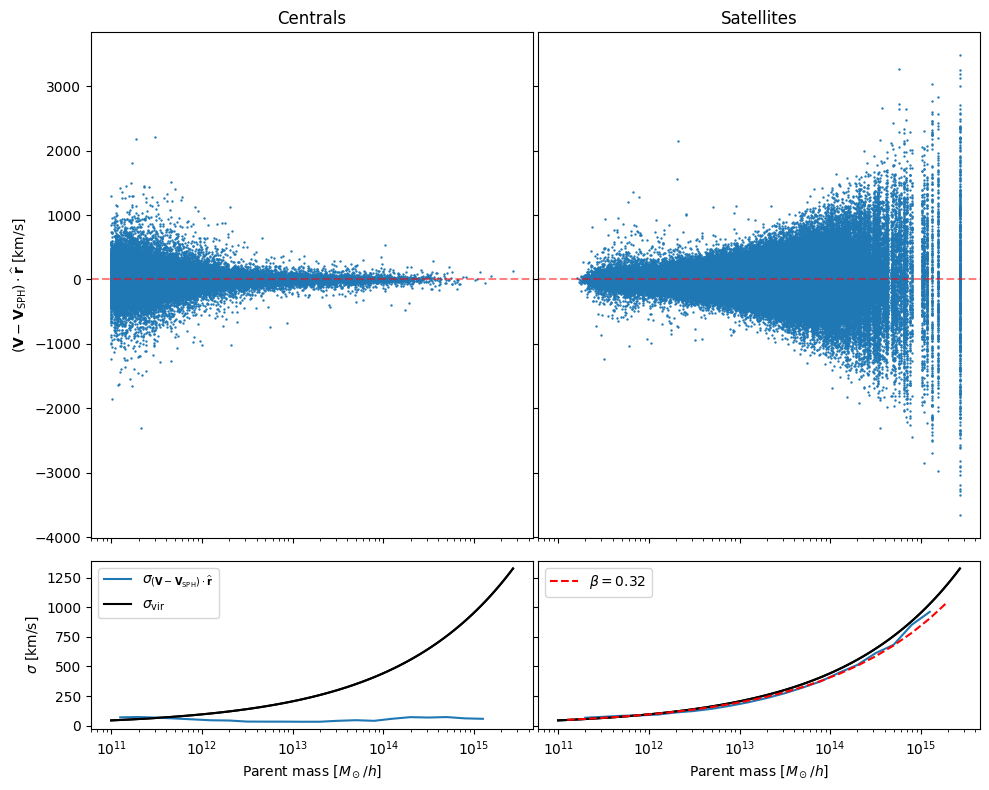

In [88]:
bins = np.arange(np.log10(np.min(parent_mass)), np.log10(np.max(parent_mass)), 0.2)
xbins = (bins[1:] + bins[:-1]) / 2
bins = 10**bins
xbins = 10**xbins


fig, axs = plt.subplots(
    nrows=2, ncols=2, figsize=(10, 8), sharey="row", sharex="col", gridspec_kw={"height_ratios": [3, 1]})
cols = plt.rcParams["axes.prop_cycle"].by_key()["color"]
fig.subplots_adjust(wspace=0.0)

# Plot the projected velocity difference
axs[0, 0].scatter(parent_mass[is_central], dvx_projected[is_central], s=0.5)
axs[0, 1].scatter(parent_mass[~is_central], dvx_projected[~ is_central], s=0.5)
plt.plot(xrange, sigma_vir(xrange), color="black")
axs[1, 0].plot(xrange, sigma_vir(xrange), color="black")

# Plot the standard deviation in a bin
xrange = np.logspace(np.log10(np.min(parent_mass)), np.log10(np.max(parent_mass)), 100)
stat, __, __ = binned_statistic(parent_mass[is_central], dvx_projected[is_central], statistic="std", bins=bins)
axs[1, 0].plot(xbins, stat, color=cols[0], label=r"$\sigma_{(\mathbf{V} - \mathbf{V}_{\rm SPH}) \cdot \widehat{\mathbf{r}}}$")
axs[1, 0].plot(xrange, sigma_vir(xrange), color="black", label=r"$\sigma_{\rm vir}$")

# Plot the standard deviation in a bin
stat, __, __ = binned_statistic(parent_mass[~is_central], dvx_projected[~is_central], statistic="std", bins=bins)
axs[1, 1].plot(xbins, stat, color=cols[0])
axs[1, 1].plot(xrange, sigma_vir(xrange), color="black")
m = np.isfinite(stat)
beta, alpha = np.polyfit(np.log10(xbins[m] / 1e15), np.log10(stat[m]), 1)
print(alpha, beta)
axs[1, 1].plot(xbins, 10**alpha * (xbins / 1e15)**beta, color="red", ls="--", label=r"$\beta = {:.2f}$".format(beta))


axs[0, 0].set_ylabel(r"$\mathbf{V} \cdot \widehat{\mathbf{r}}  ~ [\mathrm{km} / \mathrm{s}]$")
axs[0, 0].set_ylabel(r"$(\mathbf{V} - \mathbf{V}_{\rm SPH}) \cdot \widehat{\mathbf{r}}  ~ [\mathrm{km} / \mathrm{s}]$")
axs[1, 0].set_ylabel(r"$\sigma  ~ [\mathrm{km} / \mathrm{s}]$")
axs[0, 0].set_title("Centrals")
axs[0, 1].set_title("Satellites")
for i in range(2):
    axs[0, i].axhline(0, color="red", ls="--", alpha=0.5)
    axs[1, i].set_xscale("log")
    # axs[1, i].set_yscale("log")
    axs[1, i].set_xlabel(r"Parent mass $[M_\odot / h]$")

axs[1, 0].legend()
axs[1, 1].legend()


fig.tight_layout(w_pad=0)
fig.savefig("../plots/projected_residual_velocity_to_parent_mass.png", dpi=300, bbox_inches="tight")
# fig.savefig("../plots/projected_velocity_to_parent_mass.png", dpi=300, bbox_inches="tight")

fig.show()